<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-обзор-данных" data-toc-modified-id="Загрузка-и-обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и обзор данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-данных-для-обучения-моделей" data-toc-modified-id="Подготовка-данных-для-обучения-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных для обучения моделей</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-LinearRegression" data-toc-modified-id="Модель-LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Модель LinearRegression</a></span></li><li><span><a href="#Модель-CatBoostRegressor" data-toc-modified-id="Модель-CatBoostRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель CatBoostRegressor</a></span></li><li><span><a href="#Модель-LGBMRegressor" data-toc-modified-id="Модель-LGBMRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Модель LGBMRegressor</a></span></li><li><span><a href="#Модель-DecisionTreeRegressor" data-toc-modified-id="Модель-DecisionTreeRegressor-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Модель DecisionTreeRegressor</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Итоговые-выводы" data-toc-modified-id="Итоговые-выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоговые выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси для компании «Чётенькое такси»

Компания «Чётенькое такси» занимается пассажирскими перевозками и планирует в будущем привлекать больше водителей в период пиковой нагрузки.

**Цель исследования:** построение модели для определения количества заказов такси на следующий час.

Компания собрала и предоставила исторические данные о заказах такси в аэропортах.

**Заказчику важен следующий показатель:** значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Этапы исследования:**
1. Загрузка и обзор данных
2. Ресемплирование данных по одному часу
3. Анализ данных
4. Подготовка данных для обучения моделей
5. Обучение моделей
6. Анализ моделей и выбор лучшей модели
7. Написание общего вывода

## Загрузка и обзор данных

Установим и импортируем необходимые для исследования библиотеки:

In [1]:
#!pip install scikit-learn==1.6 -q

In [2]:
import pandas as pd
import numpy as np
import warnings
from numpy.random import RandomState
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import sklearn
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor

Отключим отображение предупреждений:

In [3]:
warnings.filterwarnings('ignore')
#warnings.filterwarnings('ignore', category=FutureWarning)

Откроем файл с датасетом:

In [4]:
try:
    taxi = pd.read_csv(
        '/datasets/taxi.csv',
        index_col=[0],
        parse_dates=[0]
    )
except:
    taxi = pd.read_csv(
        'https://code.s3.yandex.net/datasets/taxi.csv',
        index_col=[0],
        parse_dates=[0]
    )

Выведем первые строки и общую информацию о датафрейме `taxi`:

In [5]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Датафрейм содержит следующие данные:
* `datetime` - дата и время заказов
* `num_orders` - количество заказов

Выведем информацию о датафрейме `taxi`:

In [6]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
taxi.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


Проблем с типами данных в датафрейме не обнаружено.

Проверим датафрейм на наличие пропусков данных:

In [8]:
taxi.isna().sum()

num_orders    0
dtype: int64

Пропуски данных в датафрейме также не обнаружены.

Посмотрим, за какой период представлены данные в датафрейме:

In [9]:
print(f'Временной промежуток: с {taxi.index.min()} по {taxi.index.max()}')

Временной промежуток: с 2018-03-01 00:00:00 по 2018-08-31 23:50:00


Таким образом, мы имеем данные за 6 месяцев 2018 года - с марта по август.

Проверим хронологичность порядка расположения даты и времени:

In [10]:
if taxi.index.is_monotonic:
    print('Данные в хронологическом порядке')
else:
    print('Данные не в хронологическом порядке')

Данные в хронологическом порядке


В датафрейме данные представлены в хронологическом порядке, поэтому сортировка не требуется.

Т.к. по условию задачи необходимо предсказать заказы такси на следующий час, то проведем ресемплирование данных по часам, при этом также сделаем отдельный датафрейм с ресемплированием по дням:

In [11]:
taxi_days = taxi.copy().resample('1D').sum()
taxi = taxi.resample('1H').sum()

Проверим получившийся датафрейм:

In [12]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Проблем с данными и их типами не обнаружено, пропусков данных также нет. Заказы такси в фатафрейме располагаются в хронологическом порядке. Произведено ресемплирование данных по часам. Далее можно проводить анализ данных полученного датафрейма.

## Анализ данных

Определим функцию для отображения графика временного ряда:

In [13]:
def show_graph(data, title, xlabel, ylabel, legend_labels):
    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=data,
        palette='dark'
    ).set(
        title=title,
        xlabel=xlabel,
        ylabel=ylabel
    )
    plt.legend(
        title='Графики',
        loc='upper left',
        labels=legend_labels
    )

Отобразим на графике данные по заказам такси из датафрема:

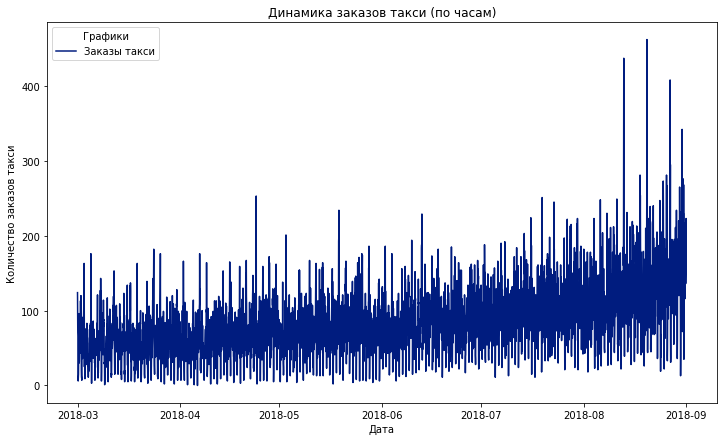

In [14]:
show_graph(
    taxi,
    'Динамика заказов такси (по часам)',
    'Дата',
    'Количество заказов такси',
    ['Заказы такси']
)

По графику временного ряда можно наблюдать восходящий тренд от начала периода к концу - заказов такси в сентябре больше, чем в марте.

Добавим на график скользящие среднее и стандартное отклонение. Возьмем размер окна, равный 168 часам (т.е. неделя):

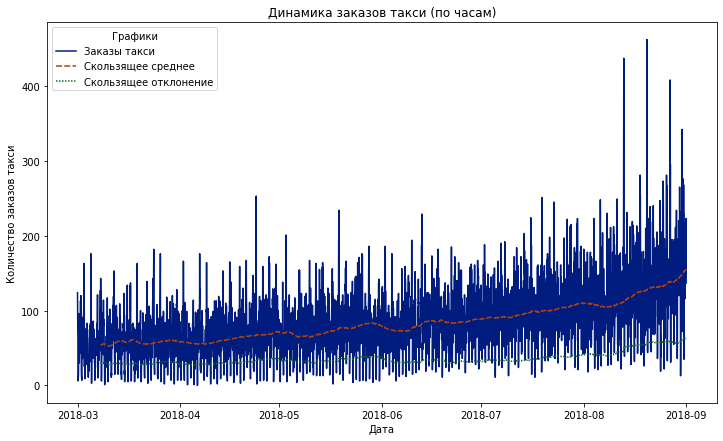

In [15]:
taxi_copy = taxi.copy()
taxi_copy['rolling_mean'] = taxi_copy['num_orders'].rolling(168).mean()
taxi_copy['rolling_std'] = taxi_copy['num_orders'].rolling(168).std()

show_graph(
    taxi_copy,
    'Динамика заказов такси (по часам)',
    'Дата',
    'Количество заказов такси',
    ['Заказы такси', 'Скользящее среднее', 'Скользящее отклонение']
)

Среднее значение постепенно увеличивается и к концу августа выходит на свой максимум.

Проанализируем тренд, сезонность и остатки:

In [16]:
decomposed = seasonal_decompose(taxi)

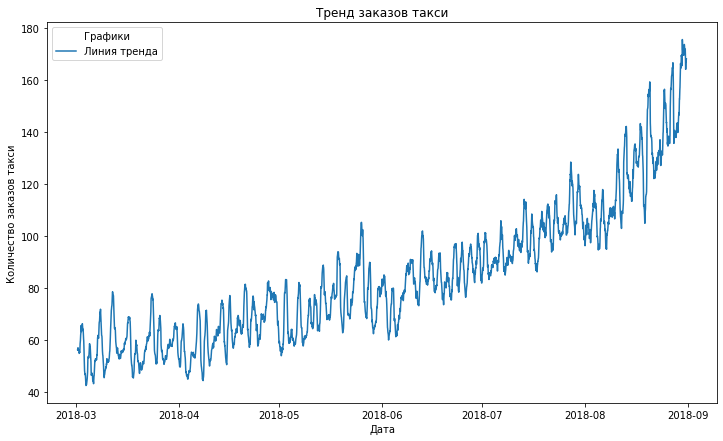

In [17]:
show_graph(
    decomposed.trend,
    'Тренд заказов такси',
    'Дата',
    'Количество заказов такси',
    ['Линия тренда']
)

Линия тренда также показывает увеличение количества заказов к концу периода - вероятно, летом и ближе к осени, люди чаще пользуются такси в виду наступления сезона отпусков.

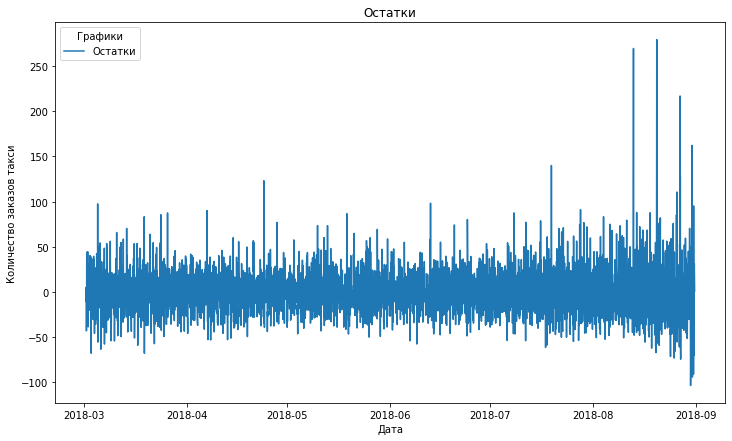

In [18]:
show_graph(
    decomposed.resid,
    'Остатки',
    'Дата',
    'Количество заказов такси',
    ['Остатки']
)

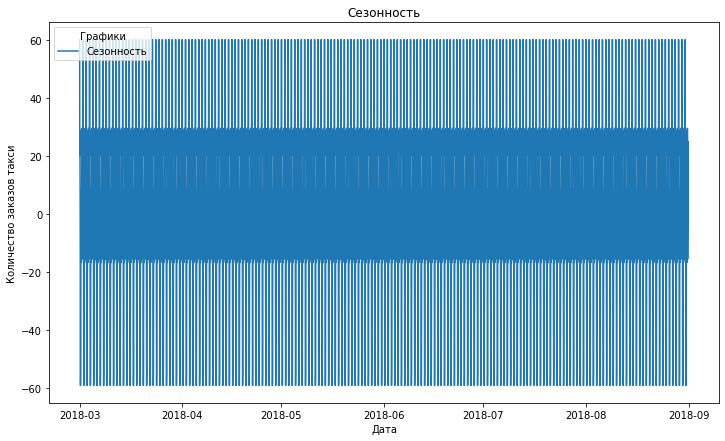

In [19]:
show_graph(
    decomposed.seasonal,
    'Сезонность',
    'Дата',
    'Количество заказов такси',
    ['Сезонность']
)

Рассмотрим график сезонности на более коротком периоде - возьмем промежуток неделю и один день (на начало периода):

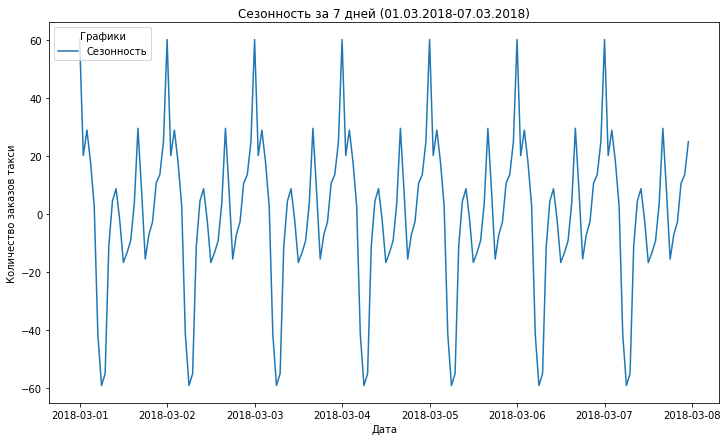

In [20]:
show_graph(
    decomposed.seasonal['2018-03-01':'2018-03-07'],
    'Сезонность за 7 дней (01.03.2018-07.03.2018)',
    'Дата',
    'Количество заказов такси',
    ['Сезонность']
)

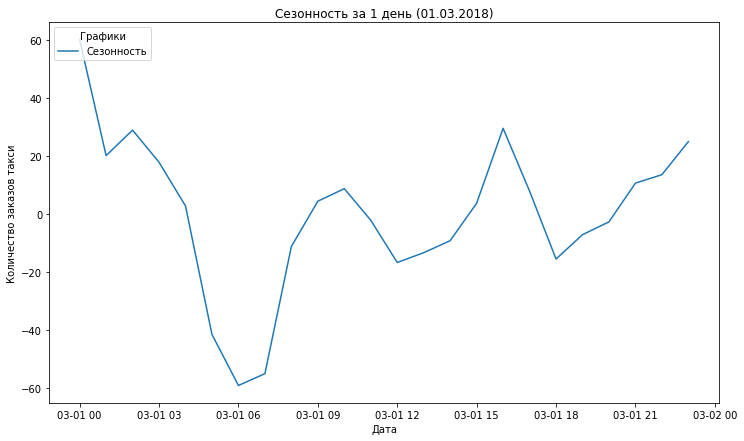

In [21]:
show_graph(
    decomposed.seasonal['2018-03-01':'2018-03-01'],
    'Сезонность за 1 день (01.03.2018)',
    'Дата',
    'Количество заказов такси',
    ['Сезонность']
)

Посмотрим сезонность за две недели по дням на датасете, который мы ранее ресемплировали по дням:

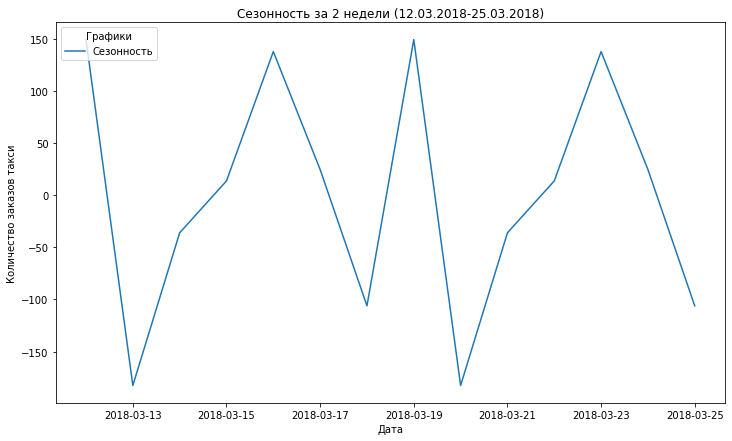

In [22]:
show_graph(
    seasonal_decompose(taxi_days).seasonal['2018-03-12':'2018-03-25'],
    'Сезонность за 2 недели (12.03.2018-25.03.2018)',
    'Дата',
    'Количество заказов такси',
    ['Сезонность']
)

Сезоннось по неделе показывает, что пик заказов такси в аэропорт приходится на понедельник (деловые командировки) и пятницу (путешествия в отпуске), минимум заказов - во вторник.

По графику можно увидеть, что имеется несколько пиков нагрузки: 10-11 часов утра, 16 часов дня и конец дня. Снижение количества заказов такси происходит ночью и достигаем минимума к 6 утра.

Временной ряд из исходного датафрейма не является стационарным, т.к. подвержен тренду, который меняется во времени.

Проверим ряд на стационарность, применив тест Дики-Фуллера:
* Нулевая гипотеза H0 - временной ряд не стационарен
* Альтернативная гипотеза H1 - временной ряд стационарен

In [23]:
test = adfuller(taxi)
print(f'Статистика теста: {test[0]}')
print(f'p-value: {test[1]}')
print('Критические значения:')
for i in test[4]:
    print(f'{i}: {test[4].get(i)}')
print(40 * '-')

if test[0] > test[4]['1%']:
    print('Нулевая гипотеза не отвергается - есть единичные корни, ряд не стационарен')
else:
    print('Нулевая гипотеза отвергается - единичных корней нет, ряд стационарен')

Статистика теста: -3.0689242890279558
p-value: 0.028940051402612906
Критические значения:
1%: -3.431842162413052
5%: -2.8621993540813637
10%: -2.567120978470452
----------------------------------------
Нулевая гипотеза не отвергается - есть единичные корни, ряд не стационарен


Тест Дики-Фуллера подтверждает, что ряд стационарный с вероятностью случайно получить этот результат в 5%, если принять вероятность в 1%, то ряд не стационарный.

## Подготовка данных для обучения моделей

Определим функцию для создания новых признаков. В датафрейм включим следующие признаки:
* Признак "День недели", т.к. ранее мы определили, что есть недельная сезонность
* Признак "Час", т.к. ранее мы определили, что есть часовая (суточная) сезонность
* Признак "Отстающие значения", т.к. это параметр авторегрессии - учет влияния вчерашних событий на сегодняшние
* Признак "Скользящее среднее", т.к. это аналог тренда - ем больше окно сглаживания, тем ровнее линия тренда

В датафрейм не будем включать следующие признаки:
* Признак "Год", т.к. у нас данных меньше года, поэтому это будет просто константа
* Признак "Месяц", аналогично признаку "Год", т.к. у нас в датафрейме по одному из шести месяцев (с марта по август) и горизонт прогноза - часы, поэтому сезонность времени года будет уже заложена просто в тренде
* Признак "День", т.к. у нас нет сезонности внутри месяца и будет просто последовательность чисел

In [24]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Добавим новые признаки в датафрейм (сдвиг и скользящее окно укажем с учетом сезонности в сутках, кратными 24):

In [25]:
make_features(taxi, 24, 48)
taxi.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим авторкорреляционную (ACF) функцию для нашего временного ряда:

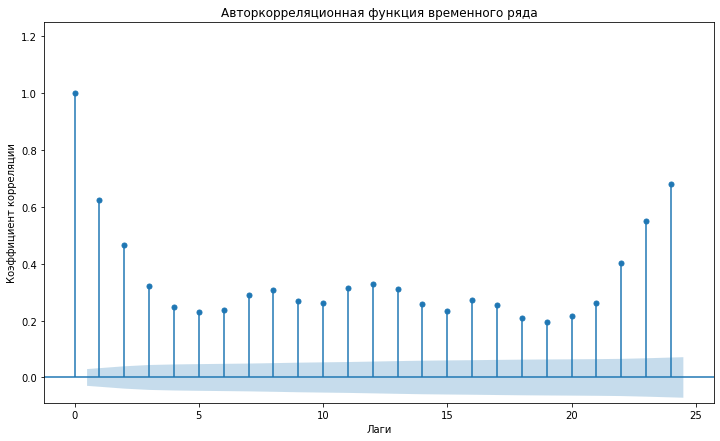

In [26]:
fig, ax = plt.subplots(figsize=(12, 7))
plot_acf(taxi['num_orders'], lags=24, auto_ylims=True, ax=ax);
ax.title.set_text('Авторкорреляционная функция временного ряда')
plt.xlabel('Лаги')
plt.ylabel('Коэффициент корреляции')
plt.show()

Чем выше столбик, тем сильнее корреляции с таргетом. Синяя область - доверительный интервал. Судя по графику, наиболее значимыми лагами являются 1 и 24 - их можно оставить в модели.

Определим переменные:

In [27]:
RANDOM_STATE = 42
TEST_SIZE = 0.1
CV = TimeSeriesSplit(n_splits=5)

Сформируем тренировочные и тестовые выборки:

In [28]:
train, test = train_test_split(
    taxi,
    shuffle=False,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (3926, 27)
X_test: (442, 27)
y_train: (3926,)
y_test: (442,)


Данные подготовлены для обучения моделей.

## Обучение моделей

Обучим следующие модели:
* Модель LinearRegression (линейная регрессия)
* Модель CatBoostRegressor (градиентный бустинг)
* Модель LightGBMRegressor (дерево принятия решений с градиентным бустингом)
* Модель DecisionTreeRegressor (дерево решений)

### Модель LinearRegression

Обучим модель линейной регрессии и посчитаем метрику *RMSE*:

In [29]:
lr_model = LinearRegression()

lr_scores = cross_val_score(
    lr_model,
    X_train,
    y_train,
    cv=CV,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

lr_model.fit(X_train, y_train)

lr_cv_rmse = - lr_scores.sum() / len(lr_scores)
print(f'Метрика RMSE на кросс-валидации: {lr_cv_rmse}')

Метрика RMSE на кросс-валидации: 27.24864549408044


### Модель CatBoostRegressor

Обучим модель градиентного бустинга и посчитаем метрику *RMSE*:

In [30]:
cbr_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)

cbr_param = {
    'iterations': range(500, 2000, 500),
    'depth': range(2, 10, 2)
}

cbr_rs = RandomizedSearchCV(
    cbr_model,
    cbr_param,
    cv=CV,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

cbr_rs.fit(X_train, y_train)

cbr_cv_rmse = - cbr_rs.best_score_
print(f'Метрика RMSE на кросс-валидации: {cbr_cv_rmse}')

Метрика RMSE на кросс-валидации: 24.106929692200378


### Модель LGBMRegressor

Обучим модель деревьев принятия решений с градиентным бустингом и посчитаем метрику *RMSE*:

In [31]:
lgbmr_model = LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)

lgbmr_param = {
    'n_estimators': range(50, 100, 10),
    'max_depth': range(3, 8),
    'num_leaves': range(10, 50, 10)
}

lgbmr_rs = RandomizedSearchCV(
    lgbmr_model, 
    lgbmr_param, 
    cv=CV,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=5
)

lgbmr_rs.fit(X_train, y_train)

lgbmr_cv_rmse = - lgbmr_rs.best_score_
print(f'Метрика RMSE на кросс-валидации: {lgbmr_cv_rmse}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ....max_depth=7, n_estimators=90, num_leaves=40; total time=   4.6s
[CV 2/5] END ....max_depth=7, n_estimators=90, num_leaves=40; total time=   9.7s
[CV 3/5] END ....max_depth=7, n_estimators=90, num_leaves=40; total time= 1.3min
[CV 4/5] END ....max_depth=7, n_estimators=90, num_leaves=40; total time= 2.1min
[CV 5/5] END ....max_depth=7, n_estimators=90, num_leaves=40; total time= 4.4min
Метрика RMSE на кросс-валидации: 24.87981303135849


### Модель DecisionTreeRegressor

Обучим модель деревьев принятия решений и посчитаем метрику *RMSE*:

In [32]:
dtr_model = DecisionTreeRegressor(random_state=RANDOM_STATE)

dtr_param = {
    'max_depth': range(2, 30),
    'max_features': range(2, 30),
    'min_samples_leaf': range(1, 30),
    'min_samples_split': range(2, 30)
}

dtr_rs = RandomizedSearchCV(
    dtr_model, 
    dtr_param, 
    cv=CV,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

dtr_rs.fit(X_train, y_train)

dtr_cv_rmse = - dtr_rs.best_score_
print(f'Метрика RMSE на кросс-валидации: {dtr_cv_rmse}')

Метрика RMSE на кросс-валидации: 28.218062361619054


## Анализ моделей

Сведем все полученные показатели по моделям в одной таблице:

In [33]:
compare_table = pd.DataFrame({
    'Модель': ['LinearRegression', 'CatBoostRegressor', 'LightGBMRegressor', 'DecisionTreeRegressor'],
    'Метрика RMSE на кросс-валидации': [lr_cv_rmse, cbr_cv_rmse, lgbmr_cv_rmse, dtr_cv_rmse]
})
compare_table

,Модель,Метрика RMSE на кросс-валидации
0,LinearRegression,27.248645
1,CatBoostRegressor,24.106930
2,LightGBMRegressor,24.879813
3,DecisionTreeRegressor,28.218062


Посчитаем предсказанные знаяение на тестовой выборке для каждой из моделей:

In [34]:
lr_y_pred = lr_model.predict(X_test)
cbr_y_pred = cbr_rs.best_estimator_.predict(X_test)
lgbmr_y_pred = lgbmr_rs.best_estimator_.predict(X_test)
dtr_y_pred = dtr_rs.best_estimator_.predict(X_test)

Составим таблицу сравнения истинных значений временного ряда тестовой выборки и предсказанных моделями значений:

In [35]:
compare_graph = pd.DataFrame({
    'y_true': y_test,
    'LinearRegression': lr_y_pred,
    'CatBoostRegressor': cbr_y_pred,
    'LightGBMRegressor': lgbmr_y_pred,
    'DecisionTreeRegressor': dtr_y_pred
})

Отобразим истинные значения временного ряда за семь дней со значениями, предсказанными моделями:

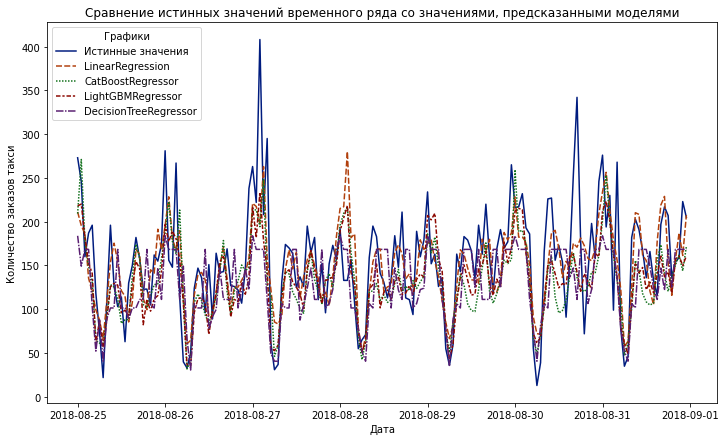

In [36]:
show_graph(
    compare_graph['2018-08-25':'2018-08-31'],
    'Сравнение истинных значений временного ряда со значениями, предсказанными моделями',
    'Дата',
    'Количество заказов такси',
    ['Истинные значения', 'LinearRegression', 'CatBoostRegressor', 'LightGBMRegressor', 'DecisionTreeRegressor']
)

Отобразим истинные значения временного ряда за семь дней со значениями, предсказанными каждой из моделей, отдельно по каждой модели:

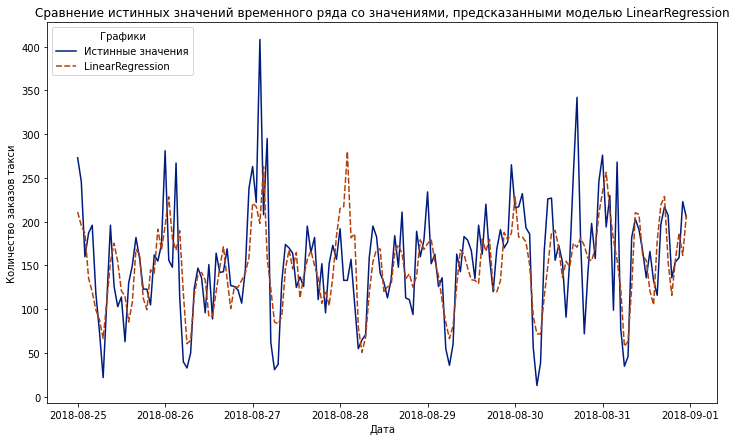

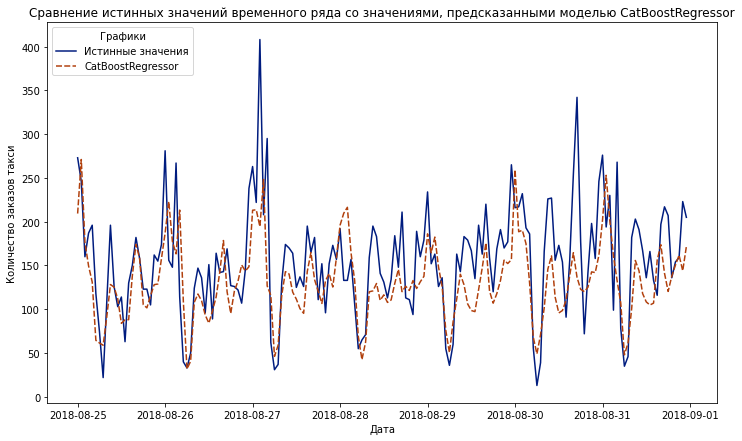

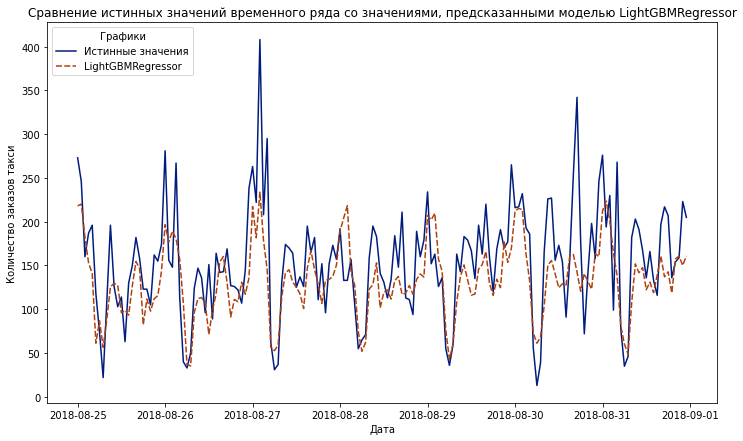

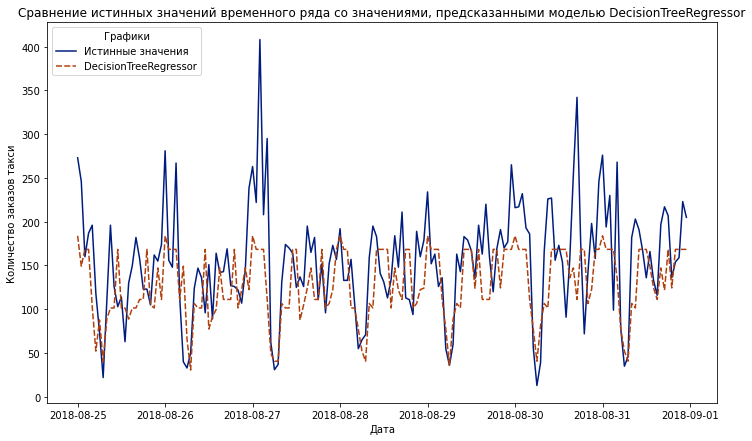

In [37]:
for i in compare_graph.columns.drop('y_true').to_list():
    show_graph(
    compare_graph[['y_true', i]]['2018-08-25':'2018-08-31'],
    f'Сравнение истинных значений временного ряда со значениями, предсказанными моделью {i}',
    'Дата',
    'Количество заказов такси',
    ['Истинные значения', i]
)

На основе полученных на кросс-валидации метрик и графиков можно сделать вывод, что модель DecisionTreeRegressor проигрывает остальным моделям. У всех моделей значения метрики *RMSE* в рамках допустимых заказчиком (меньше 48). Модели с бустингом CatBoostRegressor и LGBMRegressor показали лучшую точность прогноза, но все же предпочтение стоит отдать модели CatBoostRegressor как более точной.

Посчитаем метрику *RMSE* лучшей модели на тестовой выборке:

In [38]:
print(f'Метрика RMSE модели CatBoostRegressor на тестовой выборке: {mean_squared_error(y_test, cbr_y_pred, squared=False)}')

Метрика RMSE модели CatBoostRegressor на тестовой выборке: 42.23863237625861


## Итоговые выводы

В рамках исследования было необходимо проанализировать данные о заказах такси в аэропортах, предоставленные компанией «Чётенькое такси», которая занимается пассажирскими перевозками. Цель бизнеса - привлечение в будущем большего числа водителей в период пиковой нагрузки.

В рамках исследования было необходимо решить следующие задачи:
* Построить несколько моделей машинного обучения для определения количества заказов такси на следующий час.
* На основе заданного заказчиком порогового значения метрики *RMSE* на тестовой выборке (не больше 48) выбрать подходящую модель.

В ходе исследования при решении данных задач были реализованы следующие этапы:
* Загрузка и обзор данных
* Анализ данных
* Подготовка данных для обучения моделей
* Обучение четырех моделей
* Анализ моделей

Опираясь на условия выбора моделей, предоставленные бизнесом, и на результаты исследования, компании «Чётенькое такси» из четырех представленных моделей стоит выбрать CatBoostRegressor, т.к. она обеспечивает наиболее точный прогноз, не превышающий заданного заказчиком порогового значение метрики *RMSE*.